In [1]:
import os 
os.chdir('../../')
os.environ["DPM_TQDM"] = "False"

In [2]:
from backbones.dit import DiT

# 사용 예
model = DiT()
print(model)

/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Loading pipeline components...:   0%

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def display_class_images(pixel_samples, class_ids=None, figsize_per_image=1.5, display_title=""):
    samples = list(pixel_samples)
    processed = []
    for img in samples:
        if isinstance(img, Image.Image):
            arr = np.array(img)
        else:
            arr = np.array(img)
            if arr.ndim == 3 and arr.shape[0] in (1,3):
                arr = arr.transpose(1, 2, 0)
        processed.append(arr)

    n = len(processed)
    if class_ids is None:
        class_ids = list(range(n))

    fig, axes = plt.subplots(1, n, figsize=(n * figsize_per_image, figsize_per_image))
    if n == 1:
        axes = [axes]

    # 전체 제목 추가
    if display_title:
        fig.suptitle(display_title, fontsize=10, y=1.1)  # y 값을 1.02로 올려서 제목을 위로 이동
    # 플롯 레이아웃 조정: top을 낮춰서 제목과 플롯 사이에 공간 확보
    
    for ax, img_arr, lbl in zip(axes, processed, class_ids):
        ax.imshow(img_arr)
        ax.axis("off")
        ax.set_title(f"Class {lbl}", fontsize=8)

    plt.show()


100%|██████████| 10/10 [00:00<00:00, 23.69it/s]


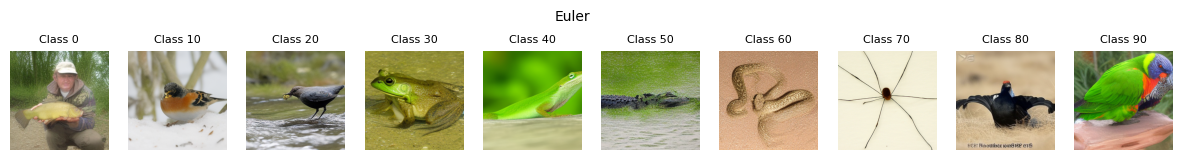

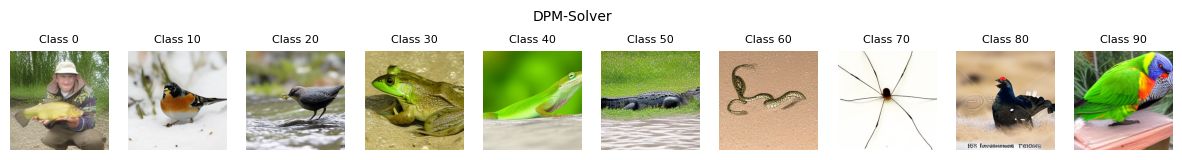

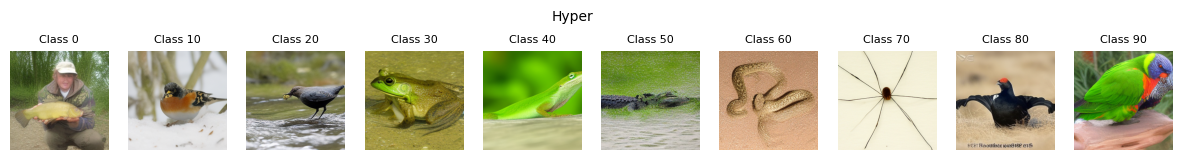

In [5]:
from solvers.euler_solver import Euler_Solver
from solvers.dpm_solver import DPM_Solver
from solvers.dual.gdual_hyper_solver import GDual_Hyper_Solver

# 클래스 0–9로 설정
class_ids = [i for i in range(0, 100, 10)]
model_fn, noise_schedule, latents = model.get_model_fn(pos_conds=class_ids, guidance_scale=3.0)

solver = Euler_Solver(model_fn, noise_schedule, algorithm_type="data_prediction")
euler_latents = solver.sample(latents, steps=10, skip_type="time_uniform")
euler_samples = model.decode_vae(euler_latents)
display_class_images(euler_samples, class_ids, display_title='Euler')

solver = DPM_Solver(model_fn, noise_schedule, algorithm_type="data_prediction")
dpm_latents = solver.sample(latents, steps=10, order=2, skip_type="time_uniform", method="multistep")
dpm_samples = model.decode_vae(dpm_latents)
display_class_images(dpm_samples, class_ids, display_title='DPM-Solver')

solver = GDual_Hyper_Solver(model_fn, noise_schedule, algorithm_type="dual_prediction")
unipc_latents = solver.sample(latents, steps=10, order=2, skip_type="time_uniform", method="multistep")
unipc_samples = model.decode_vae(unipc_latents)
display_class_images(unipc_samples, class_ids, display_title='Hyper')

